In [1]:
# Import modules
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import sh
%matplotlib inline
import json

In [2]:
!ls /home/kfgbah/Yelp/yelp/

Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
yelp_academic_dataset_business.json  yelp_academic_dataset_tip.json
yelp_academic_dataset_checkin.json   yelp_academic_dataset_user.json


In [3]:
!hdfs dfs -ls /user/kfgbah/Yelp/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 5 items
-rw-r--r--   3 kfgbah kfgbah  124380583 2021-07-28 12:53 /user/kfgbah/Yelp/yelp_academic_dataset_business.json
-rw-r--r--   3 kfgbah kfgbah  398272056 2021-07-28 12:50 /user/kfgbah/Yelp/yelp_academic_dataset_checkin.json
-rw-r--r--   3 kfgbah kfgbah 6936678061 2021-07-28 12:55 /user/kfgbah/Yelp/yelp_academic_dataset_review.json
-rw-r--r--   3 kfgbah kfgbah  230307244 2021-07-28 12:52 /user/kfgbah/Yelp/yelp_academic_dataset_tip.json
-rw-r--r--   3 kfgbah kfgbah 3684505303 2021-07-28 13:05 /user/kfgbah/Yelp/yelp_academic_dataset_user.json


In [4]:
spark = SparkSession.builder.appName('yelp_data').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),
 ('spark.yarn.historyServer.addre

In [5]:
# Read yelp data in hadoop fS
# multiple json files

yelp_df = spark.read.json("/user/kfgbah/Yelp/*.json")

In [22]:
yelp_df.show(5)

+-------+----------+-------------+--------------------+----------+----+---------------+----------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+-----+----+-------+-----+-----+-------+--------+---------+----+-----------+------------+---------+-----+-----+----+------+-------+-------------+
|address|attributes|average_stars|         business_id|categories|city|compliment_cool|compliment_count|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|                date|elite|fans|friends|funny|hours|is_open|latitude|longitude|name|postal_code|review_count|review_id|stars|state|text|useful|user_id|yelping_since|
+-------+----------+-------------+--------------------+----------+----+---------------+----------------+----------

In [23]:
#yelp_df.limit(1000).cache()

In [8]:
yelp_df.count()

12286440

In [24]:
yelp_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [10]:
yelp_df.sample(True, 0.0000001,0).toPandas()

,address,attributes,average_stars,business_id,categories,city,compliment_cool,compliment_count,compliment_cute,compliment_funny,...,name,postal_code,review_count,review_id,stars,state,text,useful,user_id,yelping_since
0,None,None,None,GO87oDnzxN5RlEJCF2Kdhw,None,None,None,None,None,None,...,None,None,None,u9YVWd7ZZfDUWgKFeAbg_w,4.0,None,Why do people mess up these stores? They act l...,0,NNmkd5pVJcpjHUGeeMzlRw,None


In [11]:
yelp_pandas_data=yelp_df.sample(True, 0.00001,0).toPandas()

In [12]:
yelp_pandas_data

,address,attributes,average_stars,business_id,categories,city,compliment_cool,compliment_count,compliment_cute,compliment_funny,...,name,postal_code,review_count,review_id,stars,state,text,useful,user_id,yelping_since
0,None,None,NaN,60X4wqzQkh9pxLV_7I7VNQ,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,W5dcg-Wgk5jxait7bCaAow,1.0,None,They won't accept a new patient unless they ha...,0.0,ujSoS09I7irCqXcMgM9Ttg,None
1,None,None,NaN,4THc7ojs6ppNHKhLl74www,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,YbAEK1ay-2iMnrMY2rfboA,2.0,None,After ordering takeout here several times I've...,2.0,8OXB2WhCWkU_XgVJSuaCwQ,None
2,None,None,NaN,wBu0t9PEDaK0GLARe12Tuw,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,fxt61Q3QwZxYptdqZGgNgQ,5.0,None,Working with Lindsey was wonderful! I chose he...,0.0,vxLy1DmwwWFxSSu_5GFvsw,None
3,None,None,NaN,z0upGkm6F_fQYtpA1h-x1g,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,ZjBhJcaYySfqELVVP9vE3Q,5.0,None,Go to this location! We got the run around wit...,2.0,BwjDHKWTK6V8Zuiicvt-7g,None
4,None,None,NaN,32bsFaGx_nRU-7c7l4Cj2Q,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,9VeWTVQ7DDUCaH0K_8vejg,4.0,None,First time we stop by this place for lunch thi...,0.0,jHuoAQwDkAH-FQWSmRZnfA,None
5,None,None,NaN,jQYIE9bjrh9EP-B5FXpqPw,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,Vtp_Ob9ibZRhJ4wNeAx91A,3.0,None,I would recommend a Homevest property to frien...,1.0,MWJ3qfjwjDGhhRxtvWa2-Q,None
6,None,None,NaN,8kI1x_5VyU7mnaUnFgJukQ,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,t35h4RRUCQX0ooPJH86svw,5.0,None,Great smoke shop. Decently sized with everythi...,1.0,wcZmo8xC4hryLSWYrYuXrg,None
7,None,None,NaN,I-fCZYwlO0eZDu9OhDVG_g,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,1NKKlFoE1FdED5lRinoa7Q,5.0,None,It's Space Mountain! One of the best rides at ...,0.0,JEwo8vAdGFX14pcbkNDm3w,None
8,None,None,NaN,DZmY0x5ih9y7KZhgHsNFpw,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,6b7PBY8tX2_i7vuf8rzmjg,2.0,None,it's sad over the years this place has slipped...,0.0,h2APdcqLnGnYqQuw-JVI_A,None
9,None,None,NaN,AjUhiD7BxVlVg9Vz8wNJFQ,None,None,NaN,NaN,NaN,NaN,...,None,None,NaN,i984s2-xmgDGVz1X1_V83w,5.0,None,The staff has amazing service and the pizza i...,0.0,NsDCU2UFg747mtItugCsQQ,None


In [13]:
#yelp_pandas_data['city']

In [14]:
yelp_pandas_data['text'][0]

"They won't accept a new patient unless they have been referred by an existing patient. Very strange policy."

In [15]:
yelp_pandas_data['text'][1]

'After ordering takeout here several times I\'ve pretty much written off Rice Bowl. Yes, it was decent enough to go back more than once, but return visits failed to provide positive reinforcement, just a growing sense of disappointment.\n\nSome items are off the beaten path of Americanized Asian food but I have no way of knowing which ones might be among their specialties - Yelpers say they specialize in Taiwanese dishes and I see several Sichuan and Japanese style items as well. Any potential standouts don\'t seem to be highlighted on the menu in any way. Shrug.\n\nWe hoped Green Onion Pancakes could be among the winners - they were interesting but never became a repeat order. Ho-hum average quality of usual-suspect dishes was tolerable because of the convenient location... at least until the last time I called in an order for Curry Chicken. That\'s a comfort-food staple for me at many other places but this version was just downright inedible. I\'m the "human garbage disposal" of the 

___
## EDA 

In [22]:
# number of partitions of the rdd
yelp_df.rdd.getNumPartitions()

87

In [23]:

## Basic Statistics
yelp_df.describe().show()

+-------+-------------------+------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------+--------------------+-----------------+--------------------+-------------------+
|summary|            address|     average_stars|         business_id|          categories|                city|   compliment_cool|    compliment_count|    compliment_cute|  compliment_funny|   compliment_hot|    compliment_list|   compliment_more|   compliment_note| compliment_photos|  compliment_

In [24]:
#count the columns with null 
clean_yelp = yelp_df.dropna()
clean_yelp.count()

0

In [25]:
%%time
#Show more than one column 
yelp_df.select("city", "address","state").distinct().show(20,truncate = False)

+------------+----------------------------+-----+
|city        |address                     |state|
+------------+----------------------------+-----+
|Milwaukie   |18500 SE Mcloughlin Blvd    |OR   |
|Vancouver   |1075 W Georgia Street       |BC   |
|Portland    |210 NW 6th Ave              |OR   |
|Lewis Center|6289 Pullman Dr             |OH   |
|Tewksbury   |2106 Main St                |MA   |
|Decatur     |3914 N Druid Hills Rd       |GA   |
|Austin      |6402 McNeil Dr, Ste 33      |TX   |
|Austin      |220 S Congress Ave          |TX   |
|Boston      |14 Bromfield St             |MA   |
|Boulder     |1669 Euclid Ave             |CO   |
|Hilliard    |5488 Roberts Rd             |OH   |
|Boston      |3 Center Plz                |MA   |
|Orlando     |4333 Silver Star Rd, Ste 135|FL   |
|Portland    |9045 SW Barbur Blvd, Ste 122|OR   |
|Columbus    |550 S High St               |OH   |
|Milton      |1259 Brook Rd               |MA   |
|Columbus    |343 N Front St              |OH   |


In [26]:
#List of distinct Results
yelp_df.select('address').distinct().count()

123896

In [27]:
#List of distinct Results
yelp_df.select('categories').distinct().show()

+--------------------+
|          categories|
+--------------------+
|Pizza, Event Plan...|
|Gift Shops, Shopp...|
|Food, Wine Bars, ...|
|Professional Serv...|
|Roofing, Home Ser...|
|Delis, Sandwiches...|
|Musicians, Lounge...|
|Event Planning & ...|
|Health & Medical,...|
|Irish, Irish Pub,...|
|Education, Health...|
|Hair Removal, Thr...|
|Skin Care, Massag...|
|Restaurants, Food...|
|Beauty & Spas, Ha...|
|Shopping, Accesso...|
|Used, Vintage & C...|
|Restaurants, Kore...|
|Seafood, American...|
|Farmers Market, F...|
+--------------------+
only showing top 20 rows



In [28]:
#List of distinct Results
yelp_df.select('business_id').distinct().count()

160586

In [29]:
%%time
#List of distinct Results
yelp_df.select('city').distinct().count()

CPU times: user 2.91 ms, sys: 2.75 ms, total: 5.66 ms
Wall time: 7.28 s


837

In [30]:
%%time
#List of distinct Results
yelp_df.select('state').distinct().count()

CPU times: user 2.61 ms, sys: 2.74 ms, total: 5.35 ms
Wall time: 6.77 s


32

In [31]:
%%time
#Approximate Count of distinct facilities
from pyspark.sql.functions import approxCountDistinct
yelp_df.select(approxCountDistinct("categories", rsd = 0.01)).show()

+---------------------------------+
|approx_count_distinct(categories)|
+---------------------------------+
|                            88562|
+---------------------------------+

CPU times: user 5.24 ms, sys: 2.09 ms, total: 7.33 ms
Wall time: 8.39 s


In [32]:
%%time
#Count resturants with missing values in the row
yelp_df.dropna().count()

CPU times: user 4.75 ms, sys: 6.38 ms, total: 11.1 ms
Wall time: 8.16 s


0

In [33]:
%%time 
#Number of rows with missing business Id count
yelp_df.dropna(thresh=1,subset=('business_id')).count()

CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 6.23 s


10096983

In [34]:
%%time 
#Number of rows with missing review Id 
yelp_df.dropna(thresh=1,subset=('review_id')).count()

CPU times: user 4.23 ms, sys: 1.09 ms, total: 5.32 ms
Wall time: 6.83 s


8635403

In [35]:
%%time 
#Replace missing Facility type value with the string "UKNOWN" 
#yelp_df = yelp_df.fillna("UNKNOWN", subset=('name'))
#yelp_df = yelp_df.fillna("UNKNOWN", subset=('address'))
#yelp_df = yelp_df.fillna("UNKNOWN", subset=('categories'))
#yelp_df = yelp_df.fillna("UNK", subset=('state'))
#yelp_df = yelp_df.fillna("UNKNOWN", subset=('city'))
#yelp_df = yelp_df.fillna("UNKNOWN", subset=('postal_code'))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


### Data Cleanup

In [36]:
#List of distinct names
yelp_df.select('name').distinct().show(truncate=False)

+---------+
|name     |
+---------+
|Sharnissa|
|K        |
|Faye     |
|Nargess  |
|Tyler    |
|Kiana    |
|Sandi    |
|Alayna   |
|Flurp    |
|Tegan    |
|July     |
|Julianne |
|Rach     |
|Alaena   |
|Reta     |
|Susanna  |
|Ritu     |
|Soni     |
|Arlindo  |
|Monie    |
+---------+
only showing top 20 rows



In [8]:
%%time 
#drop columns not needed for analysis
yelp_df = yelp_df.drop('latitude', 'longitude')

CPU times: user 2.92 ms, sys: 2.41 ms, total: 5.34 ms
Wall time: 32.2 ms


In [38]:
%%time 
#List of distinct Cities. Notice Chicago is spelt in multiple ways; let us clean this up
yelp_df.select('City').distinct().show(truncate= False)

+-----------------+
|City             |
+-----------------+
|West Vancouver   |
|Osteen           |
|Nahant           |
|Greater Boston MA|
|Hanover          |
|South Natick     |
|Worcester        |
|Harrisburg       |
|Greater Vancouver|
|St.Cloud         |
|Springfield      |
|Charleston       |
|Chestnut Hill    |
|Candler-McAfee   |
|Lawrenceville    |
|newton           |
|Obetz            |
|Waban            |
|Phoenix          |
|Sellwood         |
+-----------------+
only showing top 20 rows

CPU times: user 3.36 ms, sys: 2.31 ms, total: 5.67 ms
Wall time: 6.87 s


In [39]:
#count of distinct names
yelp_df.select('name').distinct().count()

278273

In [40]:
%%time 
yelp_df.select('City').distinct().count()

CPU times: user 2.74 ms, sys: 2.21 ms, total: 4.95 ms
Wall time: 6.59 s


837

In [6]:
#convert categorical values to upper case
from pyspark.sql.functions import upper, col

#withColumn adds/replaces columns in the dataframe
yelp_df = yelp_df.withColumn('City', upper(col('City')));
yelp_df = yelp_df.withColumn('name', upper(col('name')));

In [42]:
yelp_df.select('name').distinct().count()

268674

In [43]:
yelp_df.select('City').distinct().count()

730

In [44]:
yelp_df.select('City').distinct().show(50,truncate= False)

+------------------------+
|City                    |
+------------------------+
|WATERTOWN               |
|LOCKHART                |
|N. WEYMOUTH             |
|BOSTON-FENWAY           |
|VANVOUVER               |
|KENANSVILLE             |
|VININGS                 |
|WEST LAKE               |
|LIBERTY                 |
|VANCOVUER               |
|AVONDALE ESTATES        |
|SOMERVILLE              |
|FULTON                  |
|DOWNTOWN VANCOUVER      |
|CLARKSTON               |
|DECATUR                 |
|BRA                     |
|ORLANDO                 |
|CLARKSON                |
|FAIRBURN                |
|WINCHESTER              |
|MERRITT ISLAND          |
|ALOMA                   |
|RIDGEFIELD              |
|MEDFIELD                |
|AVON                    |
|ATLANDA                 |
|KITSILANO               |
|SMRYNA                  |
|LILBURN                 |
|ASHLAND                 |
|WESTON                  |
|HUTTO                   |
|SPRING VALLEY           |
|

In [7]:
%%time 
from pyspark.sql.functions import regexp_replace

yelp_df = yelp_df.withColumn('City', regexp_replace('City', 'ATLANDA', 'ATLANTA'))
yelp_df = yelp_df.withColumn('City', regexp_replace('City', 'VANCOVUER', 'VANCOUVER'))
yelp_df = yelp_df.withColumn('City', regexp_replace('City', 'VANVOUVER ', 'VANCOUVER'))
yelp_df = yelp_df.withColumn('City', regexp_replace('City', 'VAN COUVER ', 'VANCOUVER'))

CPU times: user 3.33 ms, sys: 4.5 ms, total: 7.84 ms
Wall time: 221 ms


In [46]:
yelp_df.select('City').distinct().count()

728

## Filtering, Grouping, Pivots and Cubes

In [47]:
yelp_df.filter(yelp_df.City == 'NEW YORK').count()#chicago

0

In [48]:
yelp_df.filter(yelp_df.City == 'ATLANTA').count()

12626

In [49]:
yelp_df.filter(yelp_df.City == 'MIAMI').count()

1

In [50]:
yelp_df.filter(yelp_df.City == 'VANCOUVER').count()

13335

In [51]:
%%time
# Get number of restaurent by city 
yelp_city_df = yelp_df.groupby("city").count()
yelp_city_df.show()

+------------------+-----+
|              city|count|
+------------------+-----+
|         WATERTOWN|  608|
|          LOCKHART|    4|
|       N. WEYMOUTH|    1|
|     BOSTON-FENWAY|    1|
|         VANVOUVER|    1|
|       KENANSVILLE|    3|
|           VININGS|    8|
|         WEST LAKE|    1|
|           LIBERTY|    1|
|  AVONDALE ESTATES|   49|
|        SOMERVILLE| 1267|
|            FULTON|    2|
|DOWNTOWN VANCOUVER|    1|
|         CLARKSTON|   41|
|          DECATUR |    1|
|               BRA|    1|
|           ORLANDO|10669|
|          CLARKSON|    1|
|          FAIRBURN|    1|
|        WINCHESTER|  167|
+------------------+-----+
only showing top 20 rows

CPU times: user 5.49 ms, sys: 435 µs, total: 5.93 ms
Wall time: 6.47 s


In [52]:
yelp_df.groupby("city").count().orderBy("count",ascending=[0]).dropna().show()

+---------------+-----+
|           city|count|
+---------------+-----+
|         AUSTIN|22433|
|       PORTLAND|18222|
|      VANCOUVER|13335|
|        ATLANTA|12626|
|        ORLANDO|10669|
|         BOSTON| 8269|
|       COLUMBUS| 6640|
|        BOULDER| 2543|
|      CAMBRIDGE| 2434|
|      BEAVERTON| 2255|
|       RICHMOND| 1794|
|        BURNABY| 1729|
|      KISSIMMEE| 1723|
|        DECATUR| 1411|
|    WINTER PARK| 1292|
|     SOMERVILLE| 1267|
|         QUINCY| 1093|
|      BROOKLINE|  986|
|NORTH VANCOUVER|  927|
|         TIGARD|  918|
+---------------+-----+
only showing top 20 rows



CPU times: user 131 ms, sys: 25.4 ms, total: 156 ms
Wall time: 6.54 s


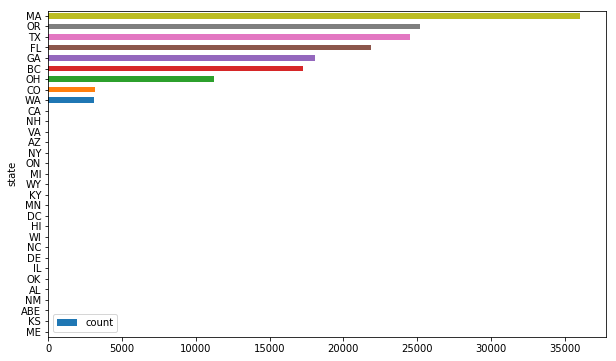

In [53]:
%%time
# Get number of restaurent by state
yelp_state_df = yelp_df.groupby("state").count()
from pyspark.sql.functions import when
yelp_state_df_1=yelp_state_df.withColumn('state2',when(yelp_state_df.state!='UNK',"True")).filter("state2==true").drop('state2')

p_yelp_state_df=yelp_state_df_1.toPandas()
p_yelp_state_df.sort_values('count', ascending=True).plot(kind='barh',x='state',y='count', figsize=(10,6))

In [54]:
## which restaurants have more comments

In [55]:
yelp_df.groupby("name", "review_count").count().orderBy("count",ascending=[0]).dropna().show()

+--------+------------+-----+
|    name|review_count|count|
+--------+------------+-----+
| MICHAEL|           1| 2890|
|    JOHN|           1| 2870|
|   DAVID|           1| 2740|
|   CHRIS|           1| 2440|
|    JOHN|           2| 2285|
| MICHAEL|           2| 2217|
|   SARAH|           1| 2114|
|   DAVID|           2| 2067|
|    MIKE|           1| 1965|
|JENNIFER|           1| 1940|
| JESSICA|           1| 1923|
|   CHRIS|           2| 1859|
|   SARAH|           2| 1825|
|    JOHN|           3| 1801|
| MICHAEL|           3| 1652|
|   DAVID|           3| 1650|
|JENNIFER|           2| 1641|
|    ALEX|           1| 1578|
|  ASHLEY|           1| 1572|
|   JAMES|           1| 1550|
+--------+------------+-----+
only showing top 20 rows



In [56]:
yelp_df.select("text").distinct().count()

9699697

In [57]:
yelp_df.dropna(thresh=1,subset=('text')).count()

9797522

In [58]:
yelp_df.groupby("name", "stars").count().orderBy("count",ascending=[0]).dropna().show()

+------------+-----+-----+
|        name|stars|count|
+------------+-----+-----+
|   STARBUCKS|  3.0|  268|
|   STARBUCKS|  3.5|  249|
|  MCDONALD'S|  2.0|  204|
|  MCDONALD'S|  1.5|  154|
|     DUNKIN'|  2.0|  147|
|     DUNKIN'|  2.5|  143|
|      SUBWAY|  2.5|  135|
|      SUBWAY|  3.0|  128|
|   STARBUCKS|  4.0|  122|
|      SUBWAY|  2.0|  122|
|   STARBUCKS|  2.5|  119|
| BURGER KING|  1.5|   97|
|CVS PHARMACY|  2.5|   92|
|   TACO BELL|  2.0|   91|
| BURGER KING|  2.0|   88|
|CVS PHARMACY|  2.0|   88|
|  MCDONALD'S|  2.5|   87|
|     DUNKIN'|  3.0|   86|
|     WENDY'S|  2.0|   84|
|   WALGREENS|  2.5|   70|
+------------+-----+-----+
only showing top 20 rows



In [59]:
yelp_df.groupby("stars").count().orderBy("count",ascending=[0]).dropna().show()

+-----+-------+
|stars|  count|
+-----+-------+
|  5.0|3834485|
|  4.0|1954093|
|  1.0|1264486|
|  3.0| 948239|
|  2.0| 719901|
|  3.5|  28835|
|  4.5|  28072|
|  2.5|  13720|
|  1.5|   4157|
+-----+-------+



In [60]:
# in which city restaurant gets higher rating in start
#yelp_df.select('city','name','stars').where 
yelp_df.cube("city", "name", "stars").count().dropna().show(truncate=False)

+---------+--------------------------------------+-----+-----+
|city     |name                                  |stars|count|
+---------+--------------------------------------+-----+-----+
|ALLSTON  |OUR FATHERS                           |3.5  |1    |
|DUBLIN   |LEGACY FAMILY DENTAL                  |4.5  |1    |
|ORLANDO  |ASTON MARTIN ORLANDO, LOTUS OF ORLANDO|5.0  |1    |
|ATLANTA  |TENTH STREET TATTOO                   |4.5  |1    |
|AUSTIN   |SAVING FACE                           |5.0  |1    |
|PORTLAND |7-ELEVEN                              |2.5  |7    |
|BELMONT  |MACY'S                                |2.5  |1    |
|COLUMBUS |SITTING MADE SIMPLE                   |2.5  |1    |
|PORTLAND |BASILISK                              |4.5  |1    |
|PORTLAND |PDX COOKIE                            |4.0  |1    |
|AUSTIN   |EXQUISITE BEAUTY SALON & SPA          |1.0  |1    |
|ATLANTA  |GRAVITY FITNESS                       |4.0  |1    |
|BOSTON   |JEFFRIES POINT                        |4.0  

In [61]:
#order states by restaurant quality
df3 = yelp_df.groupBy("state").pivot("stars").count()
df3.toPandas().sort_values("5.0",ascending=[0]).head(5)

,state,null,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
4,None,3490452.0,1262800.0,NaN,711378.0,NaN,926656.0,NaN,1920037.0,NaN,3814532.0
24,TX,NaN,220.0,606.0,1074.0,1638.0,2541.0,3722.0,4716.0,5098.0,4870.0
3,OR,NaN,163.0,423.0,947.0,1552.0,2746.0,4021.0,5452.0,5546.0,4325.0
26,MA,NaN,373.0,913.0,2036.0,3317.0,5134.0,6710.0,7410.0,5860.0,4259.0
28,FL,NaN,332.0,722.0,1314.0,2081.0,3050.0,3960.0,4797.0,3667.0,1984.0


In [62]:
#order cities by  restaurant quality
df4 = yelp_df.groupBy("city").pivot("stars").count()

df4.toPandas().sort_values("5.0",ascending=[0]).head(5)

,city,null,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
147,None,3490452.0,1262800.0,NaN,711378.0,NaN,926656.0,NaN,1920037.0,NaN,3814532.0
234,AUSTIN,NaN,206.0,556.0,964.0,1461.0,2295.0,3396.0,4354.0,4686.0,4515.0
82,PORTLAND,NaN,120.0,283.0,586.0,982.0,1785.0,2829.0,4071.0,4256.0,3310.0
34,ATLANTA,NaN,212.0,432.0,841.0,1186.0,1802.0,2403.0,2661.0,1842.0,1247.0
87,VANCOUVER,NaN,86.0,235.0,590.0,1113.0,2140.0,2831.0,3247.0,2041.0,1052.0


CPU times: user 172 ms, sys: 3.16 ms, total: 175 ms
Wall time: 383 ms


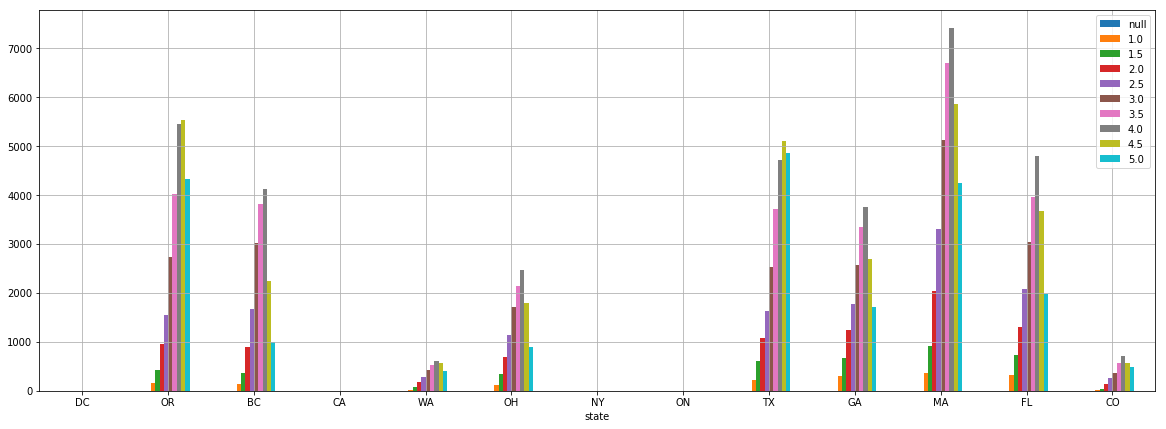

In [63]:
%%time 
#plot some of the Facility Types risk profile
pdf = df3.toPandas()
pdf[pdf["5.0"] < 5000 ].plot(figsize=(20,7), kind='bar', x="state", grid=True, rot="0")

In [64]:

df_user_city = yelp_df.groupBy("user_id","city").pivot("stars").count()

In [65]:
df_user_city.toPandas().sort_values("5.0",ascending=[0]).head()

,user_id,city,null,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
726190,None,AUSTIN,NaN,206.0,556.0,964.0,1461.0,2295.0,3396.0,4354.0,4686.0,4515.0
262986,None,PORTLAND,NaN,120.0,283.0,586.0,982.0,1785.0,2829.0,4071.0,4256.0,3310.0
297857,RtGqdDBvvBCjcu5dUqwfzA,None,4.0,211.0,NaN,585.0,NaN,1422.0,NaN,1805.0,NaN,2050.0
120371,None,ATLANTA,NaN,212.0,432.0,841.0,1186.0,1802.0,2403.0,2661.0,1842.0,1247.0
274371,None,VANCOUVER,NaN,86.0,235.0,590.0,1113.0,2140.0,2831.0,3247.0,2041.0,1052.0


In [66]:
yelp_df.select("cool").distinct().show()

+-----+
| cool|
+-----+
|   29|
|   26|
|  474|
| 5409|
|  964|
| 1806|
| 1950|
| 2214|
| 2529|
| 2453|
| 4590|
| 2509|
| 1677|
|21209|
| 3764|
| 4823|
| 3506|
|   65|
|  541|
| 1360|
+-----+
only showing top 20 rows



In [67]:
yelp_df.select("friends").distinct().show(1,truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [68]:
yelp_df.select("elite").distinct().show(truncate=False)

+-------------------------------------------------------+
|elite                                                  |
+-------------------------------------------------------+
|2012,2013,2015,2016,2017,20,20                         |
|2010,2011,2014                                         |
|2014,2017                                              |
|2008,2009,2010,2011,2015,2016,2017,2018,2019           |
|2007,2012,2013,2014,2015,2016,2017,2018,2019           |
|2013,2019,20,20                                        |
|2010,2011,2016                                         |
|2011,2012,2014,2015,2016,2017,2018                     |
|2015,2018,2019                                         |
|2010,2018,2019,20,20                                   |
|2009,2010,2011,2012,2013,2015                          |
|2009,2010,2011,2016,2017                               |
|2010,2012,20,20                                        |
|2011,2012,2013,2014,2017,2018,2019                     |
|2008,2009,201

In [69]:
yelp_df.select("funny").distinct().show(truncate=False)

+-----+
|funny|
+-----+
|29   |
|26   |
|474  |
|2927 |
|1677 |
|1697 |
|964  |
|5409 |
|15173|
|1950 |
|2453 |
|2040 |
|2250 |
|3091 |
|3506 |
|10156|
|2214 |
|1806 |
|65   |
|418  |
+-----+
only showing top 20 rows



In [70]:
yelp_df.select('name',"cool").orderBy("cool",ascending=[0]).dropna().show()

+------------+------+
|        name|  cool|
+------------+------+
|      HARALD|198451|
|         FOX|175463|
|     RICHARD|149659|
|       BRUCE|119613|
|       ARIEL|111741|
|   CHERYLYNN|103393|
|      VICTOR|100038|
|     MICHAEL| 98978|
|      ARSHAD| 92151|
|      MAGGIE| 91540|
|    MARIANNE| 90960|
|       LAURA| 89538|
|         MAY| 79572|
|       JOYCE| 61734|
|       AARON| 59715|
|        JACK| 58465|
|       PAIGE| 58206|
|          ED| 57922|
|       STACY| 57808|
|MICHELANGELO| 57181|
+------------+------+
only showing top 20 rows



In [71]:
yelp_df.select('name',"funny").orderBy("funny",ascending=[0]).dropna().show()

+------------+------+
|        name| funny|
+------------+------+
|      HARALD|172041|
|         FOX|166330|
|     RICHARD|115844|
|   CHERYLYNN| 96361|
|       BRUCE| 86387|
|      MAGGIE| 83780|
|     MICHAEL| 82359|
|      ARSHAD| 79902|
|      VICTOR| 75521|
|       AARON| 57616|
|    MARIANNE| 56602|
|          ED| 49995|
|       PETER| 47934|
|         MAY| 46206|
|       JOYCE| 45754|
|        DANI| 45720|
|        DEAN| 44676|
|MICHELANGELO| 44523|
|         JOE| 42116|
|        CARL| 41428|
+------------+------+
only showing top 20 rows



In [72]:
yelp_df.select('name',"fans").orderBy("fans",ascending=[0]).dropna().show()

+---------+-----+
|     name| fans|
+---------+-----+
|     MIKE|12116|
|    KATIE| 3511|
|CHERYLYNN| 3326|
|      FOX| 3237|
|  RICHARD| 3009|
|   DANIEL| 2938|
|    RUGGY| 2540|
|  JESSICA| 2463|
|      EMI| 2365|
|    MEGAN| 2339|
|    PETER| 2329|
|     CARL| 2285|
|       ED| 2173|
|   JEREMY| 2086|
|   FARRAH| 1953|
| BRITTANY| 1923|
|     CARA| 1915|
| BRITTANY| 1914|
|    JANDO| 1850|
|     JACK| 1848|
+---------+-----+
only showing top 20 rows



In [73]:
yelp_df.select('city',"categories").groupby("categories").count().orderBy("count",ascending=[0]).dropna().show()

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|Beauty & Spas, Ha...|  757|
|  Restaurants, Pizza|  748|
|Hair Salons, Beau...|  742|
|  Pizza, Restaurants|  740|
|Beauty & Spas, Na...|  734|
|Nail Salons, Beau...|  712|
|  Coffee & Tea, Food|  703|
|  Food, Coffee & Tea|  680|
|Restaurants, Chinese|  601|
|Chinese, Restaurants|  588|
|Mexican, Restaurants|  549|
|Restaurants, Mexican|  507|
|Automotive, Auto ...|  444|
|Auto Repair, Auto...|  422|
|Financial Service...|  390|
|Home Services, Re...|  363|
|Banks & Credit Un...|  347|
|Real Estate, Home...|  345|
|Real Estate, Apar...|  344|
|Home Services, Ap...|  342|
+--------------------+-----+
only showing top 20 rows



In [74]:
yelp_df.select('city',"categories").groupby(["city","categories"]).count().orderBy("count",ascending=[0]).dropna().show()

+---------+--------------------+-----+
|     city|          categories|count|
+---------+--------------------+-----+
|VANCOUVER|  Food, Coffee & Tea|  140|
|VANCOUVER|  Coffee & Tea, Food|  138|
|   AUSTIN|Home Services, Re...|  118|
| PORTLAND|  Coffee & Tea, Food|  109|
| PORTLAND|  Food, Coffee & Tea|  104|
|   AUSTIN|Real Estate, Apar...|  100|
|   AUSTIN|Real Estate, Home...|   99|
|   AUSTIN|Home Services, Ap...|   99|
|   AUSTIN|Mexican, Restaurants|   96|
|VANCOUVER|Beauty & Spas, Ha...|   94|
|   AUSTIN|Restaurants, Mexican|   90|
|   AUSTIN|Apartments, Real ...|   86|
|VANCOUVER|Hair Salons, Beau...|   86|
| PORTLAND|Hair Salons, Beau...|   83|
|   AUSTIN|Hair Salons, Beau...|   79|
| PORTLAND|Beauty & Spas, Ha...|   79|
|  ATLANTA|Beauty & Spas, Na...|   78|
|   AUSTIN|Apartments, Home ...|   78|
|   AUSTIN|Beauty & Spas, Ha...|   76|
| PORTLAND|Mexican, Restaurants|   76|
+---------+--------------------+-----+
only showing top 20 rows



In [75]:
yelp_df.select('name',"average_stars").groupby(["name","average_stars"]).count().orderBy("count",ascending=[0]).dropna().show()

+---------+-------------+-----+
|     name|average_stars|count|
+---------+-------------+-----+
|  MICHAEL|          5.0| 3119|
|    DAVID|          5.0| 3065|
|     JOHN|          5.0| 2988|
|    SARAH|          5.0| 2795|
|    CHRIS|          5.0| 2692|
| JENNIFER|          5.0| 2584|
|  JESSICA|          5.0| 2371|
|     MIKE|          5.0| 2093|
| MICHELLE|          5.0| 1961|
|    EMILY|          5.0| 1941|
|     LISA|          5.0| 1917|
|   ASHLEY|          5.0| 1894|
|   AMANDA|          5.0| 1802|
|      AMY|          5.0| 1799|
|   LAUREN|          5.0| 1790|
|    LAURA|          5.0| 1730|
|     ALEX|          5.0| 1721|
|STEPHANIE|          5.0| 1695|
|     MATT|          5.0| 1674|
|    KATIE|          5.0| 1669|
+---------+-------------+-----+
only showing top 20 rows



In [80]:
# get data types
yelp_df.dtypes

[('address', 'string'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>'),
 ('average_stars', 'double'),
 ('business_id', 'string'),
 ('categories', 'string'),
 ('City', 'string'),


In [20]:
yelp_df.select('name','user_id').distinct().dropna().show()

+------------+--------------------+
|        name|             user_id|
+------------+--------------------+
|       HEIDI|FWrkhpDVirhbKdd5h...|
|       KAYLA|eVwVoHBnnZe8s5Guq...|
|      VIVIAN|7O6HsbMOmH69Schkz...|
|    HARRISON|7aRiEmI9x4nc5U-8N...|
|    CHRISTIE|mtTIl3u3jrCkeiVL5...|
|       KELLY|hCtRjNzfdIzYKMuT0...|
|        BRYA|6X8dZ1798BMlFzS7u...|
|HEATHER ANNE|BD7ndGCcvFcM5_yhW...|
|        GENA|LVBwjGUOlyQpHUlxd...|
|       HEENA|FYxSoQABtwRbsBzmz...|
|      BONNIE|-FI5zpyFLHqu0w9bO...|
|        ALEX|dhNSZx8eYWtV6ChVb...|
|       KEVIN|arVZTbyRT60oWSjIx...|
|      ALEXIS|w12As9wykdLASkwmb...|
|        ALEX|2dsRg6h8Rd6ajRtvJ...|
|     JESSICA|CpYKVtvE6qrzkgW9f...|
|        KIUK|QD_DycJxqwP3SKCXs...|
|        JOTE|S7UFdA0JvihGTZXVo...|
|     SABRINA|s6sUGF0TQMjklCh8Y...|
|     GINETTE|cYDmlkOrzwvz4VgUw...|
+------------+--------------------+
only showing top 20 rows



In [81]:
yelp_df.select('name','business_id').distinct().dropna().show()

+--------------------+--------------------+
|                name|         business_id|
+--------------------+--------------------+
|   CREATURE COMFORTS|ZQ02hYhOhQssZF5wH...|
|MOYO GRILL & BAR ...|FuQExkWBNIYRXShoP...|
|          THE BURREN|xGXzsc-hzam-VArK6...|
|  MEGA NAILS AND SPA|DQsMWjNBWPzWDidja...|
|CAPITAL PAIN INST...|jGm59EccuIvO2mLgR...|
|  ZARA HAIR BRAIDING|VsCUHyXK03LnRP0tt...|
|      HUETIFUL SALON|Qbb_U9MpeaEa76gCz...|
|   WHOLE BODY HEALTH|9ZjNkXuwZeqXo3bzj...|
|CRAFTED OUTDOOR L...|G_39hrg42VJpyhpGv...|
|             WAFFOLD|XsQ_jdoFcHLwqfuay...|
|THAI 5 AND SUSHI BAR|Y6xGZZIQEtwjCkVHL...|
| SMILE CENTER DENTAL|bq584jJzpz8WeQ5jz...|
|GRANO BAKERY AND ...|HA8vcoaLhqDM_1SdJ...|
|24/7 ANIMAL HOSPI...|IkuEsjCw_S5x8wqJ9...|
|KEPLER'S UPHOLSTE...|2nga6kqwUZ3CiAlY7...|
|        HENRY'S  ATX|8eJ1gEaswRl6TAZmn...|
|BUCK'S BIKES SUPE...|6PGwg4yEhK2GyS_wq...|
|          UBREAKIFIX|DxnetFsBuKf3T4bVk...|
|        HAIR CUTTERY|kByDLpciStwzrwooq...|
|   THE FABULOUS MAID|JY0HqZtN2F

### Explore by date and time

In [89]:
yelp_df.select('hours').distinct().dropna().show(truncate=False)

+---------------------------------------------------------------------------------+
|hours                                                                            |
+---------------------------------------------------------------------------------+
|[11:0-18:30, 10:0-20:0, 11:0-18:30, 11:0-18:30, 11:0-18:30,, 11:0-18:30]         |
|[6:0-22:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 6:0-22:0]           |
|[8:0-19:0, 13:0-19:0, 13:0-15:0,, 13:0-19:0, 13:0-19:0, 13:0-19:0]               |
|[12:0-22:0,, 14:0-22:0, 12:0-21:0, 16:0-21:0, 16:0-21:0, 16:0-21:0]              |
|[10:0-18:0, 0:0-0:0, 10:0-18:0, 11:0-18:0, 10:0-18:0, 10:0-18:0, 10:0-18:0]      |
|[8:0-13:0, 8:0-13:0, 8:0-14:0,, 11:0-16:0, 8:0-13:0, 14:0-19:0]                  |
|[11:30-22:30, 0:0-0:0, 11:0-22:30, 11:0-21:0, 11:30-22:0, 16:0-22:0, 11:30-22:0] |
|[7:0-22:0, 7:0-22:0, 7:0-22:0, 9:0-14:0, 7:0-22:0, 7:0-22:0, 7:0-22:0]           |
|[10:0-17:30, 10:0-15:0, 10:0-16:0,, 10:0-17:30, 10:0-17:30, 10:0-17:30]    

In [8]:
yelp_df.select('date').distinct().dropna().show(truncate=False)

+-------------------+
|date               |
+-------------------+
|2020-07-17 01:38:55|
|2019-05-06 18:00:30|
|2016-06-10 03:18:24|
|2018-09-04 15:20:15|
|2018-08-17 10:50:42|
|2014-06-09 03:44:54|
|2019-10-02 01:51:59|
|2018-12-20 06:35:50|
|2018-01-04 04:17:04|
|2016-01-12 17:45:10|
|2018-02-03 23:34:38|
|2020-03-06 23:55:34|
|2014-11-17 18:28:02|
|2020-02-16 02:36:15|
|2020-07-10 17:44:00|
|2017-03-08 17:54:16|
|2016-07-09 20:15:29|
|2015-07-26 01:11:07|
|2016-10-14 21:21:20|
|2019-08-02 06:03:22|
+-------------------+
only showing top 20 rows



In [9]:
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
#df2=df1.withColumn("date", unix_timestamp('date','MM/dd/yyyy').cast('timestamp'))
yelp_df=yelp_df.withColumn("date", unix_timestamp('date','yyyy-MM-dd HH:mm:ss').cast('timestamp'))

In [10]:
yelp_df.select('date').distinct().dropna().show(truncate=False)

+-------------------+
|date               |
+-------------------+
|2011-09-28 18:45:44|
|2015-09-11 00:22:46|
|2018-06-10 19:01:54|
|2018-05-09 13:04:45|
|2016-09-07 03:26:26|
|2012-10-11 23:01:50|
|2017-01-29 02:37:50|
|2008-05-22 13:21:52|
|2014-08-25 23:33:17|
|2016-06-01 16:18:00|
|2017-12-30 16:54:24|
|2017-08-17 22:31:43|
|2017-02-21 03:17:35|
|2013-10-26 18:24:47|
|2017-03-16 08:03:43|
|2013-04-12 21:08:11|
|2011-12-02 02:25:00|
|2013-03-19 20:12:48|
|2014-11-15 03:30:00|
|2014-04-21 14:47:02|
+-------------------+
only showing top 20 rows



In [11]:
yelp_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [12]:
%%time
from pyspark.sql.functions import month, year
yelp_df = yelp_df.withColumn('Year', year(yelp_df['date']))
yelp_df = yelp_df.withColumn('Month', month(yelp_df['date']))
yelp_df.select('Year','Month').distinct().dropna().show()

+----+-----+
|Year|Month|
+----+-----+
|2012|   10|
|2007|    6|
|2005|    5|
|2010|    7|
|2010|   12|
|2015|    2|
|2019|   10|
|2017|    3|
|2008|    8|
|2017|    8|
|2014|    4|
|2009|   11|
|2020|    6|
|2005|   10|
|2019|    5|
|2017|   10|
|2018|   10|
|2016|    7|
|2015|   12|
|2016|   11|
+----+-----+
only showing top 20 rows

CPU times: user 5.81 ms, sys: 3.63 ms, total: 9.44 ms
Wall time: 11.1 s


In [13]:
yelp_df.select('Year').distinct().dropna().count()

18

In [14]:
yelp_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [15]:
%%time
#Group by Year and Month and sort in asending order
yelp_df.groupBy('Year', 'Month').count().orderBy(["Year", "Month"], ascending=[0, 0]).dropna().show(truncate = False)

+----+-----+------+
|Year|Month|count |
+----+-----+------+
|2021|1    |46787 |
|2020|12   |47976 |
|2020|11   |47196 |
|2020|10   |55980 |
|2020|9    |54733 |
|2020|8    |57720 |
|2020|7    |53528 |
|2020|6    |46428 |
|2020|5    |35681 |
|2020|4    |25408 |
|2020|3    |52806 |
|2020|2    |79040 |
|2020|1    |80904 |
|2019|12   |78566 |
|2019|11   |77834 |
|2019|10   |87269 |
|2019|9    |88488 |
|2019|8    |101114|
|2019|7    |103199|
|2019|6    |99590 |
+----+-----+------+
only showing top 20 rows

CPU times: user 8.35 ms, sys: 3.46 ms, total: 11.8 ms
Wall time: 10.8 s


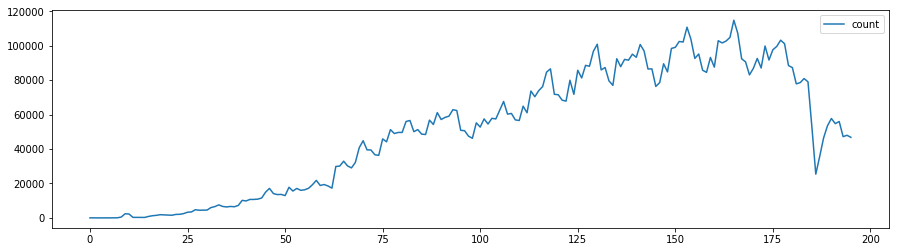

In [16]:
# plot ratings over years

yelp_df_time = yelp_df.groupBy('Year', 'Month').count().orderBy(["Year", "Month"], ascending=[1, 1]).dropna()
p_yelp_df_time = yelp_df_time.toPandas()
p_yelp_df_time.plot(y="count", figsize=(15,4), style="-")

### We see that rating have increased steadily over the years in general. This drop corresponds to the lockdown period were restaurants were closed all over the country. in recent months restaurants activities has started, rating also are picking up.

In [17]:
p_df = p_yelp_df_time.pivot(index='Month', columns='Year', values='count')
p_df

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Month,,,,,,,,,,,,,,,,,,
1,NaN,1.0,863.0,4758.0,10197.0,17799.0,29869.0,45877.0,56792.0,55214.0,64879.0,79941.0,92435.0,89509.0,93178.0,92601.0,80904.0,46787.0
2,NaN,4.0,1267.0,4466.0,9863.0,15605.0,30103.0,44183.0,54246.0,52750.0,61049.0,71764.0,87837.0,84780.0,87551.0,87064.0,79040.0,NaN
3,NaN,25.0,1497.0,4541.0,10737.0,17118.0,32934.0,51276.0,61144.0,57492.0,73666.0,85738.0,92054.0,98401.0,102890.0,99803.0,52806.0,NaN
4,NaN,48.0,1872.0,4557.0,10733.0,16035.0,30201.0,48986.0,57136.0,54540.0,70376.0,81266.0,91590.0,99052.0,101601.0,91683.0,25408.0,NaN
5,NaN,70.0,1754.0,6012.0,10903.0,16327.0,29038.0,49637.0,58384.0,57822.0,73910.0,88578.0,95073.0,102451.0,102687.0,97628.0,35681.0,NaN
6,NaN,502.0,1593.0,6576.0,11580.0,17200.0,32196.0,49635.0,59085.0,57478.0,76274.0,88067.0,93274.0,102122.0,104797.0,99590.0,46428.0,NaN
7,NaN,2412.0,1546.0,7575.0,14964.0,19255.0,40779.0,56001.0,62839.0,62550.0,84629.0,96718.0,100702.0,110747.0,114777.0,103199.0,53528.0,NaN
8,NaN,2271.0,2028.0,6668.0,17138.0,21781.0,44819.0,56557.0,62362.0,67611.0,86565.0,100865.0,96922.0,103725.0,107260.0,101114.0,57720.0,NaN
9,NaN,320.0,2101.0,6367.0,14139.0,18838.0,39510.0,50080.0,50873.0,60270.0,71792.0,85924.0,86453.0,92617.0,92393.0,88488.0,54733.0,NaN


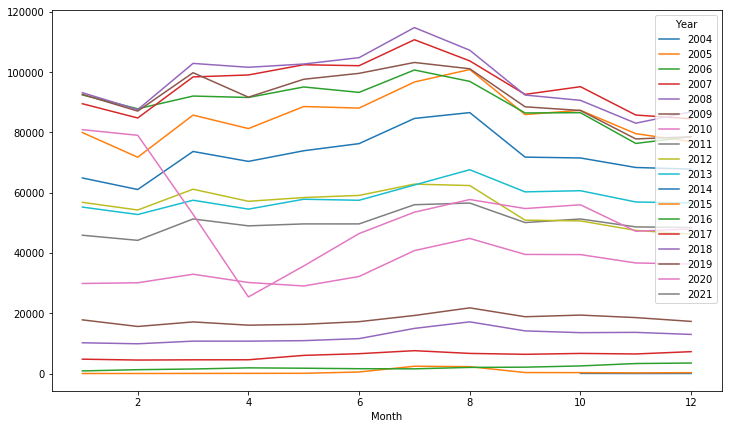

In [18]:
p_df.plot(figsize=(12,7))

### year 2020 raing dropped in number starting in Februrary which corresponds to the start of the covid-19 pandemic in the country.

In [56]:
%%time
#min,max and avg rating in each month
yelp_df_time.groupBy('Month').agg(F.min('count'),F.max('count'),F.avg('count')).orderBy("Month",ascending=[0]).show(truncate=False)


+-----+----------+----------+------------------+
|Month|min(count)|max(count)|avg(count)        |
+-----+----------+----------+------------------+
|12   |12        |86833     |44124.470588235294|
|11   |2         |85758     |44119.117647058825|
|10   |38        |95162     |48168.76470588235 |
|9    |320       |92617     |50931.125         |
|8    |2028      |107260    |58462.875         |
|7    |1546      |114777    |58263.8125        |
|6    |502       |104797    |52899.8125        |
|5    |70        |102687    |51622.1875        |
|4    |48        |101601    |49067.75          |
|3    |25        |102890    |52632.625         |
|2    |4         |87837     |48223.25          |
|1    |1         |93178     |50682.58823529412 |
+-----+----------+----------+------------------+

CPU times: user 8.94 ms, sys: 5.87 ms, total: 14.8 ms
Wall time: 38.2 s


 ### low average raing months correspond to a decrease in restaurants activities which coresponds to winter months Decenber, January and February and Peak months are June July, August

In [49]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import month, year

yelp_df = yelp_df.withColumn('Weekday', date_format('date','E'))                 

In [50]:
yelp_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [51]:
yelp_df.select("Weekday").distinct().dropna().show()

+-------+
|Weekday|
+-------+
|    Sun|
|    Mon|
|    Thu|
|    Sat|
|    Wed|
|    Fri|
|    Tue|
+-------+



In [52]:
yelp_df.select("Weekday").dropna().show()

+-------+
|Weekday|
+-------+
|    Sun|
|    Fri|
|    Fri|
|    Mon|
|    Wed|
|    Sun|
|    Sat|
|    Mon|
|    Mon|
|    Wed|
|    Wed|
|    Sun|
|    Tue|
|    Sat|
|    Sun|
|    Mon|
|    Fri|
|    Fri|
|    Wed|
|    Wed|
+-------+
only showing top 20 rows



## String Operations

In [61]:
yelp_df.select('text').dropna().show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [60]:
%%time
#how many restaurants where review mention great place with 4 stars
yelp_df.filter("text like '%GREAT PLACE%' or text like '%great place%'").filter("stars == '4.0'").count()

CPU times: user 6.53 ms, sys: 459 µs, total: 6.99 ms
Wall time: 24.3 s


44518

In [62]:
%%time
#how many restaurants where review mention great place with 4 stars
yelp_df.filter("text like '%GREAT FOOD%' or text like '%great food%'").filter("stars == '5.0'").count()

CPU times: user 3.3 ms, sys: 3.82 ms, total: 7.11 ms
Wall time: 25.7 s


45851

In [63]:
%%time
#how many restaurants where review mention great place with 4 stars
yelp_df.filter("text like '%excelent service%' or text like '%EXCELENT SERVICE%'").filter("stars == '5.0'").groupby('name').count()

CPU times: user 3.99 ms, sys: 3.08 ms, total: 7.07 ms
Wall time: 23.8 s


20

In [71]:

#how many restaurants where review mention great place with 4 stars
yelp_df.filter("text like '%expensive%' or text like '%EXPENSIVE%'").filter("stars == '5.0'").groupby('business_id').count().dropna().show(truncate=False)


+----------------------+-----+
|business_id           |count|
+----------------------+-----+
|ThOLQb-gzAYgvnIG4Kmlxg|12   |
|ZbD1yKuzecbySCdr07UNVg|3    |
|Zl8Sr4fhdnKattLhChw4jA|1    |
|TiCUcSETSP0xyVO8F7ineQ|1    |
|PBfFmFy8C0WOtpHF_frVWA|10   |
|FbZLY5XASP9phByStRTSaw|2    |
|FHg9KXpigcqABhYztXBFTA|1    |
|6vEpJRUMhjsFxEZZ08FN9A|1    |
|rncWwJUCCGXIKXeu6syqmw|3    |
|h51BbU1JJlhXrVMmmLus_A|2    |
|bxy3khT-2R66tcdKjFa2pw|14   |
|W60O4ast9uAq03n7nzcHSw|12   |
|WpEBBnYo_cXHes-MsNZuMw|1    |
|PvsrQOlk1T6reEzpXzRmCw|1    |
|3ZVgig7uux9jVtEZna5NgA|6    |
|tM8jYNX-rk5HWzBJFdOquA|2    |
|MdJ0IQp___BgwoSNJqlQIg|1    |
|45EH2iW0jryvhQ5ieNrIFg|2    |
|Z4s-jloB4oHDcsraCkRLdg|1    |
|3l-DALnAnPVKndBbzubgLA|1    |
+----------------------+-----+
only showing top 20 rows



In [73]:
%%time
#how many restaurants where review mention great place with 4 stars
yelp_df.filter("text like '%GREAT FOOD%' or text like '%great food%'").filter("stars == '5.0'").groupby('business_id').count().dropna().show(truncate=False)

+----------------------+-----+
|business_id           |count|
+----------------------+-----+
|ZjNHsN5ICnmxCz7TvHdZjQ|2    |
|H2KAvHOGz1wRHJoS-u4fpQ|1    |
|18zCSuupFXh6wIygXZmM1g|5    |
|ly8RyiktGZwwVSAv6KZEtQ|4    |
|UK5t99N509A12UjUnrWdpw|1    |
|_hkHeU2cBH9fzthIdxhuxA|2    |
|OXcBg_6vgi-J3nZzITnJFA|3    |
|PvsrQOlk1T6reEzpXzRmCw|7    |
|Vq6VFZg0b9HKAfrEG2-vEg|3    |
|W60O4ast9uAq03n7nzcHSw|7    |
|f3teByaeIKPTYetAawUtxg|5    |
|3ZVgig7uux9jVtEZna5NgA|4    |
|bxy3khT-2R66tcdKjFa2pw|6    |
|HEV0wCSeNwDoiDD4_XdO2w|1    |
|6KGBXOeSJYf9ePdyAUmx3g|9    |
|li6T8oPXvPPO-_52MTdVEQ|2    |
|OuBUzqGj02xunvlIsWrbOQ|3    |
|WFMr4GqwbS117puOwMPuqA|1    |
|lC0NqgRwn_BtOcl0xlz-VA|2    |
|iuvGguPTSW2p42f1TowNwg|4    |
+----------------------+-----+
only showing top 20 rows

CPU times: user 5.48 ms, sys: 2.79 ms, total: 8.27 ms
Wall time: 6.24 s
